---
title: "Integration test for your Gibbs sampler"
excerpt: "Making your MCMC code ready for production."
---

This summer at [Civis Analytics](https://www.civisanalytics.com/), my project was to derive and implement a Gibbs sampler for one of the company's core algorithms. While I've written several Gibbs samplers, they are one-off projects that pay little attention to robustness and maintainability. Now that my code will be read by other engineers and used to make business decisions worth many (undisclosed number) of dollars, I think a lot more about how to productionize MCMC code.

Traditionally, the way a Gibbs sampler is taught in [lecture notes](https://people.duke.edu/~ccc14/sta-663/MCMC.html#gibbs-sampler) or [tutorials](https://theclevermachine.wordpress.com/2012/11/05/mcmc-the-gibbs-sampler/) is a giant loop iterating through each parameter's full conditional. This no-frill Gibbs sampler is fast to run, relying on `numpy` operations. However, it can only be integration tested, which is slow and non-deterministic.

By contrast, [Grosse and Duvenaud (2014)](https://arxiv.org/abs/1412.5218) proposes writing the Gibbs sampler in a modular way, in which each parameter's full conditional is refactored into its own function. This modular Gibbs sampler facilitates unit testing, which is fast and deterministic. However, it is slow to run due to the overhead of creating classes and objects.

In my work, I combine both approaches to ensure that our production code is both fast to run and to test. In this first post, I write the fast, no-frill Gibbs sampler that can be integration tested. Then, in [the second post]({{ site.baseurl }}{% post_url 2017-08-16-productionizing-Gibbs-sampler-unit-test %}), I write the modular Gibbs sampler that can be unit tested, following [Grosse and Duvenaud (2014)](https://arxiv.org/abs/1412.5218). Finally, we can use the result from the modular, unit-tested Gibbs sampler to check the fast, no-frill Gibbs sampler. Once we're assured that the fast, no-frill Gibbs is correct, we can use it in production.

## Fast, no-frill Gibbs sampler

As an example throughout this series, I'll use the Gibbs sampler for the univariate normal model. It's a simple and common model, which you can find implemented in other tutorials and textbooks to compare with my approach. 

Below is the model's setup and its full conditionals, taken from [Hoff (2009), ch. 5](https://www.amazon.com/Bayesian-Statistical-Methods-Springer-Statistics/dp/1441928286). You can skip the math -- I write it here in case you want to check that it matches my code.

**Likelihood**

$$Data = Y_1, \dots, Y_n \sim i.i.d. N(\theta, \sigma^2)$$

**Prior**

$$
\begin{align}
p(\theta) &\sim N(\mu_0, \tau^2_0) \\
p(\sigma^2) &\sim Inverse-Gamma(\nu_0 / 2, \nu_0 \sigma^2_0 / 2) 
\end{align}
$$

**Full conditional**

$$
\begin{align} 
p(\theta | \tilde \sigma^2, Data) &= N(\mu_n, \tau^2_n) \\
p( \sigma^2 | \theta, Data) &= Inverse-Gamma(\frac{\nu_n}{2}, \frac{\nu_n \sigma_n^2(\theta)}{2}) 
\end{align} 
$$

where

$$
\begin{align} 
\tau_n^2 = \frac{1}{\frac{1}{\tau_0^2} + \frac{n}{\sigma^2}} \qquad &\text{and} \qquad \mu_n = \tau_n^2 \left( \frac{\mu_0}{\tau_0^2} + \frac{n\bar y}{\sigma^2} \right) \\
\nu_n = \nu_0 + n \qquad &\text{and} \qquad \sigma^2_n(\theta) = \frac{1}{\nu_n} \left[ \nu_0\sigma_0^2 + \sum (y_i - \theta)^2\right]
\end{align}
$$

We then draw \\( \theta \\) and \\( \sigma^2 \\) iteratively:

$$
\begin{align}
\theta &\sim p(\theta_s | \sigma_{s-1}^2, data) \\
\sigma^2 &\sim p(\sigma_{s}^2 | \theta_s, data)
\end{align}
$$

**We implement this iterative updating in a big loop as follows**

In [1]:
import numpy as np
import scipy.stats
import pandas as pd

def gibbs_simple(S, y, prior, rng=None):
    """
    A no-frill Gibbs sampler
    
    Parameters
    ----------
    S : int, the number of samples
    y : data vector
    prior : dict, prior parameters
    rng : int, random seed
    """
    n = len(y)
    ybar = y.mean()

    # Initialize storage
    theta_samples = np.empty(S)
    sigma2_samples = np.empty(S)

    # Starting value as the sample variance and mean
    sigma2_samples[0] = y.var()
    theta_samples[0] = ybar

    # Big loop
    for s in range(1, S):
        # Update theta
        tau2_n = 1 / (1 / prior['tau2_0'] + n / sigma2_samples[s - 1])
        mu_n = tau2_n * (prior['mu_0'] / prior['tau2_0'] + n * ybar / sigma2_samples[s - 1])
        theta_samples[s] = scipy.stats.norm(mu_n, np.sqrt(tau2_n)).rvs(random_state=rng)

        # Update sigma2
        nu_n = prior['nu_0'] + n
        nu_sigma2_n = prior['nu_0'] * prior['sigma2_0'] + sum((y - theta_samples[s]) ** 2)
        sigma2_samples[s] = scipy.stats.invgamma(nu_n / 2, scale=nu_sigma2_n / 2).rvs(random_state=rng)
        
    return {'theta': theta_samples, 'sigma2': sigma2_samples}

## Integration test

This no-frill Gibbs sampler is fast, taking full advantage of `numpy` operations. We can test its correctness by generating data from known parameters, then check whether the Gibbs sampler produces posterior estimates that are "close enough" to the known parameter values. From a programming perspective, this can be considered an [integration test](http://softwaretestingfundamentals.com/integration-testing/).

In [2]:
# Generate the data from known parameters
true_theta = 2
true_sigma2 = 3.5
y = np.random.normal(true_theta, np.sqrt(true_sigma2), size = 1000)
prior = {'mu_0': 0, 'tau2_0': 10000, 'nu_0': 1, 'sigma2_0': 1}

# Run the Gibbs sampler
samples_gibbs_simple = gibbs_simple(1000, y, prior)

We can inspect the result visually, checking that the posterior distributions (the black density plot) covers the true parameter values (the red line).

/Users/anh/miniconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


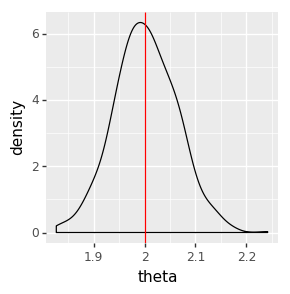

<ggplot: (292462214)>

In [3]:
from plotnine import *
from plotnine import options

options.figure_size = (3, 3)
ggplot(data=pd.DataFrame(samples_gibbs_simple)) + \
    geom_density(aes(x='theta')) + \
    geom_vline(aes(xintercept=true_theta), color='red')

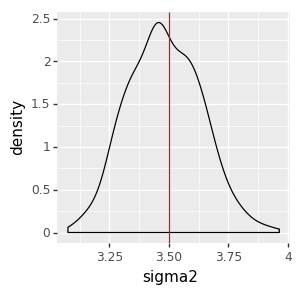

<ggplot: (295662656)>

In [4]:
options.figure_size = (3, 3)
ggplot(data=pd.DataFrame(samples_gibbs_simple)) + \
    geom_density(aes(x='sigma2')) + \
    geom_vline(aes(xintercept=true_sigma2), color='red')

We should also encode this visual check into a formal test, which can be put in an automated testing framework like `pytest` or `nose`:

In [5]:
# Checking that the posterior mean of a parameter is "close enough" to its true value
assert np.allclose(samples_gibbs_simple['theta'].mean(), true_theta, rtol=0.99)
assert np.allclose(samples_gibbs_simple['sigma2'].mean(), true_sigma2, rtol=0.99)

The integration test "works," but suffers from several drawbacks. First, the integration test can be misleading because it relies on checking a "close enough" result. Second, the integration test is slow because it has to generate the posterior sample each time. In [Part 2]({{ site.baseurl }}{% post_url 2017-08-16-productionizing-Gibbs-sampler-unit-test %}), I will discuss how to avoid these problems with a modular Gibbs sampler that can be unit-tested.